In [1]:
#Changing the working directory to the root
%cd ../../

c:\Users\ajaoo\Desktop\Projects\Multivate-forecasting


In [2]:
import pandas as pd
import numpy as np


import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from itertools import cycle
# pio.renderers.default = "notebook_connected"
import os
from pathlib import Path
import warnings
import matplotlib.dates as mdates
import torch

warnings.filterwarnings("ignore")

In [3]:
source_data = Path("data/")
# Check if a GPU is available
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
data = pd.read_csv("data/merged_data.csv")
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,Vax_index,dailyCases,cumulativeCases
0,2020-04-02,1494.0,26264,12135.0,2932,0.33,4097,41174
1,2020-04-03,1788.0,28828,13635.0,2564,0.33,4102,45276
2,2020-04-04,1950.0,31421,15469.0,2593,0.33,3405,48681
3,2020-04-05,2097.0,34013,16657.0,2592,0.33,3094,51775
4,2020-04-06,2264.0,36692,17154.0,2679,0.33,4407,56182


In [5]:
data["date"] = pd.to_datetime(data["date"])
data = data.drop(columns=["cumulativeCases", "cumAdmissions"])
data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases
0,2020-04-02,1494.0,12135.0,2932,0.33,4097
1,2020-04-03,1788.0,13635.0,2564,0.33,4102
2,2020-04-04,1950.0,15469.0,2593,0.33,3405
3,2020-04-05,2097.0,16657.0,2592,0.33,3094
4,2020-04-06,2264.0,17154.0,2679,0.33,4407


In [6]:
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig


def mase(actual, predicted, insample_actual):
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample


def forecast_bias(actual, predicted):
    return np.mean(predicted - actual)


def plot_forecast(
    pred_df, forecast_columns, forecast_display_names=None, save_path=None
):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2  # Using a different color palette
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual data plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].covidOccupiedMVBeds,
            mode="lines",
            marker=dict(size=6, opacity=0.5),
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds trends",
        )
    )

    # Predicted data plot
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

In [7]:
# Find the minimum and maximum dates
min_date = data["date"].min()
max_date = data["date"].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

# Calculate the date ranges for train, val, and test sets
date_range = max_date - min_date
train_end = min_date + pd.Timedelta(days=date_range.days * 0.75)
val_end = train_end + pd.Timedelta(days=date_range.days * 0.10)

# Split the data into train, validation, and test sets based on the date ranges
train = data[data["date"] < train_end]
val = data[(data["date"] >= train_end) & (data["date"] < val_end)]
test = data[data["date"] >= val_end]

# Calculate the percentage of dates in each dataset
total_samples = len(data)
train_percentage = len(train) / total_samples * 100
val_percentage = len(val) / total_samples * 100
test_percentage = len(test) / total_samples * 100

print(
    f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}"
)
print(
    f"Percentage of Dates in Train: {train_percentage:.2f}% | Percentage of Dates in Validation: {val_percentage:.2f}% | Percentage of Dates in Test: {test_percentage:.2f}%"
)
print(
    f"Max Date in Train: {train.date.max()} | Min Date in Validation: {val.date.min()} | Min Date in Test: {test.date.min()}"
)

Minimum Date: 2020-04-02 00:00:00
Maximum Date: 2023-05-31 00:00:00
# of Training samples: 866 | # of Validation samples: 115 | # of Test samples: 174
Percentage of Dates in Train: 74.98% | Percentage of Dates in Validation: 9.96% | Percentage of Dates in Test: 15.06%
Max Date in Train: 2022-08-15 00:00:00 | Min Date in Validation: 2022-08-16 00:00:00 | Min Date in Test: 2022-12-09 00:00:00


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 0 to 865
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 866 non-null    datetime64[ns]
 1   covidOccupiedMVBeds  866 non-null    float64       
 2   hospitalCases        866 non-null    float64       
 3   newAdmissions        866 non-null    int64         
 4   Vax_index            866 non-null    float64       
 5   dailyCases           866 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 47.4 KB


In [9]:
train.to_csv(source_data / "train.csv")
val.to_csv(source_data / "val.csv")
test.to_csv(source_data / "test.csv")

In [10]:
class LogTime:
    from time import time

    def __enter__(self):
        self.start_time = self.time()
        print("Starting operation...")

    def __exit__(self, type, value, traceback):
        elapsed_time = self.time() - self.start_time
        print(f"Operation completed in {elapsed_time} seconds.")


def add_lags(df, lags, column):
    added_features = []
    for lag in lags:
        lag_col_name = f"{column}_lag_{lag}"
        df[lag_col_name] = df[column].shift(lag)
        added_features.append(lag_col_name)
    # Drop rows with NaN values
    df.dropna(inplace=True)
    return df, added_features

In [11]:
lags = [1, 7]

data_with_lags, added_features = add_lags(data, lags, "covidOccupiedMVBeds")

In [12]:
data_with_lags.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_7
7,2020-04-09,2546.0,18423.0,2340,0.33,4076,2561.0,1494.0
8,2020-04-10,2820.0,18669.0,2196,0.33,3590,2546.0,1788.0
9,2020-04-11,2865.0,18604.0,1955,0.33,3085,2820.0,1950.0
10,2020-04-12,2881.0,18974.0,1791,0.33,2958,2865.0,2097.0
11,2020-04-13,2872.0,18621.0,1912,0.33,3463,2881.0,2264.0


In [13]:
def add_seasonal_rolling_features(df, rolls, seasonal_periods, columns, agg_funcs):
    added_features = []

    for column in columns:
        for roll in rolls:
            for period in seasonal_periods:
                for func in agg_funcs:
                    roll_column = f"{column}_roll_{roll}_period_{period}_{func}"

                    # Calculate the rolling feature
                    rolled = df[column].rolling(window=roll * period)
                    if func == "mean":
                        df[roll_column] = rolled.mean()
                    elif func == "std":
                        df[roll_column] = rolled.std()

                    added_features.append(roll_column)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df, added_features

In [14]:
# Define parameters for the function
rolls = [1]
seasonal_periods = [7]  # Example: 7 days for weekly, 30 days for monthly
columns = ["covidOccupiedMVBeds", "hospitalCases", "newAdmissions", "dailyCases"]
agg_funcs = ["mean"]

with LogTime():
    data, added_features = add_seasonal_rolling_features(
        data, rolls, seasonal_periods, columns, agg_funcs
    )

print(f"Features Created: {','.join(added_features)}")

Starting operation...
Operation completed in 0.0030379295349121094 seconds.
Features Created: covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean


In [15]:
data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean
13,2020-04-15,2847.0,17934.0,1608,0.33,4240,2849.0,2561.0,2811.428571,18539.571429,1951.571429,3568.571429
14,2020-04-16,2838.0,17783.0,1777,0.33,4360,2847.0,2546.0,2853.142857,18448.142857,1871.142857,3609.142857
15,2020-04-17,2780.0,16728.0,1674,0.33,4088,2838.0,2820.0,2847.428571,18170.857143,1796.571429,3680.285714
16,2020-04-18,2868.0,16850.0,1411,0.33,4142,2780.0,2865.0,2847.857143,17920.285714,1718.857143,3831.285714
17,2020-04-19,2820.0,16928.0,1475,0.33,3494,2868.0,2881.0,2839.142857,17628.000000,1673.714286,3907.857143


In [16]:
from src.feature_engineering.temporal_features import add_temporal_features

# Temporarily reset the index
data_reset = data.reset_index()

with LogTime():
    data_reset, added_features = add_temporal_features(
        data_reset,
        field_name="date",
        frequency="D",
        add_elapsed=True,
        drop=False,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

# Set the 'date' column back as the index
data = data_reset.set_index("date")

Starting operation...
Operation completed in 0.006541252136230469 seconds.
Features Created: _Month,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed


In [17]:
data.head()

,index,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,...,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,13,2847.0,17934.0,1608,0.33,4240,2849.0,2561.0,2811.428571,18539.571429,...,2,0,0,0,0,0,2,2,106,1586908800
2020-04-16,14,2838.0,17783.0,1777,0.33,4360,2847.0,2546.0,2853.142857,18448.142857,...,2,0,0,0,0,0,3,3,107,1586995200
2020-04-17,15,2780.0,16728.0,1674,0.33,4088,2838.0,2820.0,2847.428571,18170.857143,...,2,0,0,0,0,0,4,4,108,1587081600
2020-04-18,16,2868.0,16850.0,1411,0.33,4142,2780.0,2865.0,2847.857143,17920.285714,...,2,0,0,0,0,0,5,5,109,1587168000
2020-04-19,17,2820.0,16928.0,1475,0.33,3494,2868.0,2881.0,2839.142857,17628.000000,...,2,0,0,0,0,0,6,6,110,1587254400


In [18]:
# from src.transforms.target_transformations import AutoStationaryTransformer

# # Set the target variable
# target = "covidOccupiedMVBeds"

# # Initialize the AutoStationaryTransformer with a seasonality period
# # Adjust the seasonal_period based on your data's seasonality (for example, 7 for weekly seasonality)
# seasonal_period = 7
# auto_stationary = AutoStationaryTransformer(seasonal_period=seasonal_period)

# # Fit and transform the target column to make it stationary
# data_stat = auto_stationary.fit_transform(data[[target]], freq="D")

# # Replace the original target values with the transformed stationary values
# data[target] = data_stat.values

# # Print the transformed data to check
# data.head()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-04-15 to 2023-05-31
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   index                                     1142 non-null   int64  
 1   covidOccupiedMVBeds                       1142 non-null   float64
 2   hospitalCases                             1142 non-null   float64
 3   newAdmissions                             1142 non-null   int64  
 4   Vax_index                                 1142 non-null   float64
 5   dailyCases                                1142 non-null   int64  
 6   covidOccupiedMVBeds_lag_1                 1142 non-null   float64
 7   covidOccupiedMVBeds_lag_7                 1142 non-null   float64
 8   covidOccupiedMVBeds_roll_1_period_7_mean  1142 non-null   float64
 9   hospitalCases_roll_1_period_7_mean        1142 non-null   float64
 10  newAdmissions_roll

In [20]:
data.columns

Index(['index', 'covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions',
       'Vax_index', 'dailyCases', 'covidOccupiedMVBeds_lag_1',
       'covidOccupiedMVBeds_lag_7', 'covidOccupiedMVBeds_roll_1_period_7_mean',
       'hospitalCases_roll_1_period_7_mean',
       'newAdmissions_roll_1_period_7_mean', 'dailyCases_roll_1_period_7_mean',
       '_Month', '_Quarter', '_Is_quarter_end', '_Is_quarter_start',
       '_Is_year_end', '_Is_year_start', '_Is_month_start', '_WeekDay',
       '_Dayofweek', '_Dayofyear', '_Elapsed'],
      dtype='object')

In [21]:
# Get the minimum and maximum date from the data
min_date = data.index.min()
max_date = data.index.max()

# Calculate the range of dates
date_range = max_date - min_date

# Define the end date for the training set (75% of the data) and validation set (10% of the data)
train_end = min_date + pd.Timedelta(days=date_range.days * 0.75)
val_end = train_end + pd.Timedelta(days=date_range.days * 0.10)

# Split the data into train, validation, and test sets based on the date ranges
train = data[data.index < train_end]
val = data[(data.index >= train_end) & (data.index < val_end)]
test = data[data.index >= val_end]

# Calculate the percentage of dates in each dataset
total_samples = len(data)
train_percentage = len(train) / total_samples * 100
val_percentage = len(val) / total_samples * 100
test_percentage = len(test) / total_samples * 100

print(
    f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}"
)
print(
    f"Percentage of Dates in Train: {train_percentage:.2f}% | Percentage of Dates in Validation: {val_percentage:.2f}% | Percentage of Dates in Test: {test_percentage:.2f}%"
)
print(
    f"Max Date in Train: {train.index.max()} | Min Date in Validation: {val.index.min()} | Min Date in Test: {test.index.min()}"
)

# of Training samples: 856 | # of Validation samples: 114 | # of Test samples: 172
Percentage of Dates in Train: 74.96% | Percentage of Dates in Validation: 9.98% | Percentage of Dates in Test: 15.06%
Max Date in Train: 2022-08-18 00:00:00 | Min Date in Validation: 2022-08-19 00:00:00 | Min Date in Test: 2022-12-11 00:00:00


In [22]:
train.to_csv(source_data / "model_data/targetTransf_train.csv")
val.to_csv(source_data / "model_data/targetTransf_val.csv")
test.to_csv(source_data / "model_data/targetTransf_test.csv")

In [23]:
# Concatenate the DataFrames
sample_df = pd.concat([train, val, test])

# Convert feature columns to float32
# Exclude the 'type' column from conversion as it's a string column
for col in sample_df.columns:
    if col != "type":
        sample_df[col] = sample_df[col].astype("float32")

sample_df.head()

,index,covidOccupiedMVBeds,hospitalCases,newAdmissions,Vax_index,dailyCases,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,...,_Quarter,_Is_quarter_end,_Is_quarter_start,_Is_year_end,_Is_year_start,_Is_month_start,_WeekDay,_Dayofweek,_Dayofyear,_Elapsed
date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,13.0,2847.0,17934.0,1608.0,0.33,4240.0,2849.0,2561.0,2811.428467,18539.572266,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,106.0,1.586909e+09
2020-04-16,14.0,2838.0,17783.0,1777.0,0.33,4360.0,2847.0,2546.0,2853.142822,18448.142578,...,2.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,107.0,1.586995e+09
2020-04-17,15.0,2780.0,16728.0,1674.0,0.33,4088.0,2838.0,2820.0,2847.428467,18170.857422,...,2.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,108.0,1.587082e+09
2020-04-18,16.0,2868.0,16850.0,1411.0,0.33,4142.0,2780.0,2865.0,2847.857178,17920.285156,...,2.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,109.0,1.587168e+09
2020-04-19,17.0,2820.0,16928.0,1475.0,0.33,3494.0,2868.0,2881.0,2839.142822,17628.000000,...,2.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,110.0,1.587254e+09


In [24]:
columns_to_select = [
    "covidOccupiedMVBeds_lag_1",
    "covidOccupiedMVBeds_lag_7",
    "covidOccupiedMVBeds_roll_1_period_7_mean",
    "hospitalCases_roll_1_period_7_mean",
    "newAdmissions_roll_1_period_7_mean",
    "dailyCases_roll_1_period_7_mean",
    "_Month",
    "_WeekDay",
    "_Dayofweek",
    "_Dayofyear",
    "Vax_index"
]

In [25]:
sample_df = sample_df[columns_to_select]
sample_df.head()

,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_roll_1_period_7_mean,hospitalCases_roll_1_period_7_mean,newAdmissions_roll_1_period_7_mean,dailyCases_roll_1_period_7_mean,_Month,_WeekDay,_Dayofweek,_Dayofyear,Vax_index
date,,,,,,,,,,,
2020-04-15,2849.0,2561.0,2811.428467,18539.572266,1951.571411,3568.571533,4.0,2.0,2.0,106.0,0.33
2020-04-16,2847.0,2546.0,2853.142822,18448.142578,1871.142822,3609.142822,4.0,3.0,3.0,107.0,0.33
2020-04-17,2838.0,2820.0,2847.428467,18170.857422,1796.571411,3680.285645,4.0,4.0,4.0,108.0,0.33
2020-04-18,2780.0,2865.0,2847.857178,17920.285156,1718.857178,3831.285645,4.0,5.0,5.0,109.0,0.33
2020-04-19,2868.0,2881.0,2839.142822,17628.000000,1673.714233,3907.857178,4.0,6.0,6.0,110.0,0.33


In [26]:
cols = list(sample_df.columns)
cols.remove("covidOccupiedMVBeds_lag_7")
sample_df = sample_df[cols + ["covidOccupiedMVBeds_lag_7"]]

In [27]:
target = "covidOccupiedMVBeds_lag_7"
pred_df = pd.concat([train[[target]], val[[target]]])
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-04-15 to 2023-05-31
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   covidOccupiedMVBeds_lag_1                 1142 non-null   float32
 1   covidOccupiedMVBeds_roll_1_period_7_mean  1142 non-null   float32
 2   hospitalCases_roll_1_period_7_mean        1142 non-null   float32
 3   newAdmissions_roll_1_period_7_mean        1142 non-null   float32
 4   dailyCases_roll_1_period_7_mean           1142 non-null   float32
 5   _Month                                    1142 non-null   float32
 6   _WeekDay                                  1142 non-null   float32
 7   _Dayofweek                                1142 non-null   float32
 8   _Dayofyear                                1142 non-null   float32
 9   Vax_index                                 1142 non-null   float32
 10  covidOccupiedMVBed

In [28]:
import shutil
import random
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from src.dl.multivariate_models import (
    SingleStepRNNConfig,
    SingleStepRNNModel,
    Seq2SeqConfig,
    Seq2SeqModel,
    TransformerConfig,
    TransformerModel,
)
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from tqdm.notebook import tqdm

# For reproduceability set a random seed

torch.set_float32_matmul_precision("high")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

pl.seed_everything(42)

Seed set to 42


42

In [29]:
datamodule = TimeSeriesDataModule(
    data=sample_df,
    n_val=val.shape[0],
    n_test=test.shape[0],
    window=7,  # 7 days window
    horizon=1,  # single step
    normalize="global",  # normalizing the data
    # batch_size=32,
    num_workers=0,
)
datamodule.setup()

In [30]:
# Check a few batches from the training dataloader
train_loader = datamodule.train_dataloader()
for x, y in train_loader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    break

Input batch shape: torch.Size([32, 7, 11])
Output batch shape: torch.Size([32, 1, 1])


In [31]:
rnn_config = SingleStepRNNConfig(
    rnn_type="GRU",
    input_size=11,  # 25 for multivariate time series
    hidden_size=128,  # 64 hidden units
    num_layers=10,
    bidirectional=True,
    learning_rate=1e-3,
    # lr_scheduler_params={"step_size": 10, "gamma": 0.1}
)
model = SingleStepRNNModel(rnn_config)
model.float()

SingleStepRNNModel(
  (rnn): GRU(11, 128, num_layers=10, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (loss): MSELoss()
)

In [32]:
trainer = pl.Trainer(
    accelerator="gpu",
    # strategy='ddp_notebook',
    devices=1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=15, mode="min")],
)
trainer.fit(model, datamodule)
# Removing artifacts created during training
shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 2.8 M 
1 | fc   | Linear  | 257   
2 | loss | MSELoss | 0     
---------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.106    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [33]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()
# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds_lag_7"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [34]:
metric_record = []

In [35]:
algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": algorithm_name,
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds_lag_7"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({"Vanilla LSTM": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)
print(metrics)

{'Algorithm': 'GRU', 'MAE': '22.1042', 'MSE': '634.4338', 'MASE': '1.1201', 'Forecast Bias': '-21.95'}


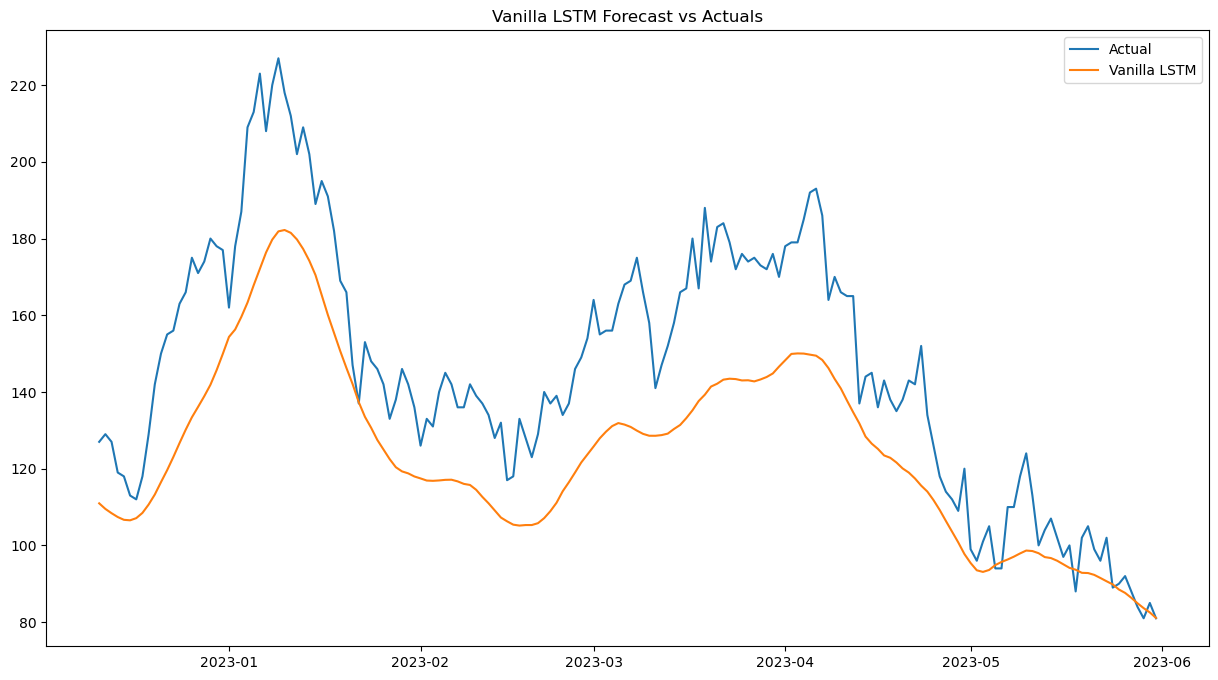

In [36]:
# code to plot the forecast with the actuals in matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(pred_df.index, pred_df["covidOccupiedMVBeds_lag_7"], label="Actual")
ax.plot(pred_df.index, pred_df["Vanilla LSTM"], label="Vanilla LSTM")
ax.set_title("Vanilla LSTM Forecast vs Actuals")
ax.legend()
plt.show()

In [38]:
# Generate the forecast plot

fig = plot_forecast(
    pred_df,
    forecast_columns=["Vanilla LSTM"],
    forecast_display_names=["Vanilla LSTM"],
)

# Set the title of the plot
title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name}"
fig = format_plot(fig, title=title)

# Update the x-axis of the plot
fig.update_xaxes(
    type="date", range=["2023-01-01", "2023-04-01"], dtick="M1", tickformat="%b %Y"
)

# Show the plot
fig.show()

# Save the plot as an image
fig.write_image(f"images/forecast_multivarate_{algorithm_name}", engine="kaleido",format="pdf")

ValueError: 
The kaleido executable is required by the kaleido Python library, but it was not included
in the Python package and it could not be found on the system PATH.

Searched for included kaleido executable at:
    c:\Users\ajaoo\miniconda3\envs\modern_ts_2E\Lib\site-packages\kaleido\executable\kaleido.cmd 

Searched for executable 'kaleido' on the following system PATH:
    c:\Users\ajaoo\miniconda3\envs\modern_ts_2E
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0\
    C:\Windows\System32\OpenSSH\
    C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR
    C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common
    C:\Program Files\Git\cmd
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0\
    C:\WINDOWS\System32\OpenSSH\
    C:\Program Files\Docker\Docker\resources\bin
    C:\Strawberry\c\bin
    C:\Strawberry\perl\site\bin
    C:\Strawberry\perl\bin
    C:\Program Files\dotnet\
    C:\Program Files\Git LFS
    C:\Users\ajaoo\AppData\Local\Programs\Python\Launcher\
    C:\Users\ajaoo\AppData\Local\Microsoft\WindowsApps
    C:\Users\ajaoo\AppData\Local\Programs\Microsoft VS Code\bin
    C:\ProgramData\olarinoyem\GitHubDesktop\bin
    C:\Users\ajaoo\AppData\Local\Programs\MiKTeX\miktex\bin\x64\
    C:\Users\ajaoo\AppData\Local\GitHubDesktop\bin
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0\
    C:\Windows\System32\OpenSSH\
    C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR
    C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common
    C:\Program Files\Git\cmd
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0\
    C:\WINDOWS\System32\OpenSSH\
    C:\Program Files\Docker\Docker\resources\bin
    C:\Strawberry\c\bin
    C:\Strawberry\perl\site\bin
    C:\Strawberry\perl\bin
    C:\Program Files\dotnet\
    C:\Program Files\Git LFS
    C:\Users\ajaoo\AppData\Local\Programs\Python\Launcher\
    C:\Users\ajaoo\AppData\Local\Microsoft\WindowsApps
    C:\Users\ajaoo\AppData\Local\Programs\Microsoft VS Code\bin
    C:\ProgramData\olarinoyem\GitHubDesktop\bin
    C:\Users\ajaoo\AppData\Local\Programs\MiKTeX\miktex\bin\x64\
    C:\Users\ajaoo\AppData\Local\GitHubDesktop\bin


In [ ]:
# multistep forecasting
seq2seq_config = Seq2SeqConfig(
    encoder_type="GRU",
    decoder_type="GRU",
    hidden_size=128,
    num_layers=10,
    bidirectional=True,
    learning_rate=1e-4,
    teacher_forcing_ratio=0.5,
    lr_scheduler=True,
)

TypeError: Seq2SeqConfig.__init__() got an unexpected keyword argument 'hidden_size'